In [11]:
import pandas as pd
import matplotlib
import statistics as stat
import math
import numpy as np

# Modules as Functions

## Atmospheric Exchange

k: piston velocity of do (m/day)

do: observed DO (mg/L)

do_sat: DO saturation calculated as a function of water temperature (mg/L)

z: depth of the mixing layer (m)

output: amount of oxygen going to the atmosphere (mg/L/day)

In [12]:
def f_atm_calc(k, do, do_sat, z, method = "process"):
    if method == "process":
        f = k * (do - do_sat) / z
    else:
        print("This method is not supported")
        return
    return f

# k.zeng

In [ ]:
def calc_zeng(dateTime,Ts,airT,Uz,RH,atm.press,wnd.z,airT.z,RH.z):
  
  psi <- function(k,zeta){
    chik <- (1 - 16*zeta)^0.25
    if (k == 1){
      psi <- 2*log((1 + chik)*0.5) + log((1+chik*chik)*0.5) - 2*atan(chik) + (pi/2)
    } else{
      psi <- 2*log((1 + chik*chik)*0.5)
    }
  }
  
  # generate data.frame of all variables (to ensure consistent times)
  dat <- pd.DataFrame({"dateTime" = dateTime, "Ts" = Ts, "airT" = airT, "Uz" = Uz, "RH" = RH})
  
  # remove duplicated time stamps
  ## dat["dateTime"] <- as.POSIXct(strptime(dat$dateTime,"%Y-%m-%d %H:%M")) # ensure times are POSIXct
  ## dat <- subset(dat,!duplicated(dat$dateTime)) #remove duplicate time stamps
  
  # store original dates - used for final data frame
  original_dates = pd.DataFrame(dateTime = dat$dateTime)  
  
  # remove missing data
  dat <-  dat[complete.cases(dat),]
  
  # re-define variables
  Ts <- dat$Ts
  airT <- dat$airT
  Uz <- dat$Uz
  RH <- dat$RH
  
  # if temperature and humidity height are missing, assume same as wind
  if (missing(airT.z)){airT.z <- wnd.z}
  if (missing(RH.z)){RH.z <- wnd.z}

  # define constants
  const_vonKarman = 0.41 # von Karman constant
  const_gas = 287.1 # gas constant for dry air J kg-1 K-1
  const_SpecificHeatAir = 1005 # Specific heat capacity of air, J kg-1 K-1
  const_Charnock = 0.013 # charnock constant
  const_Gravity = 9.81 # gravitational acceleration, m/s2

  # ensure wind below 0.2 are changed to 0.1
  thres = 0.2
  if Uz < thres:
    Uz = thres/2 #m/s

  # calculate humidity values
  e_s = 6.11*math.exp(17.27*airT/(237.3 + airT)) # saturated vapour pressure at airT, mb
  e_a = RH*e_s/100 # vapour pressure, mb
  q_z = 0.622*e_a/atm.press # specific humidity, kg kg-1 
  e_sat = 6.11*math.exp(17.27*Ts/(237.3 + Ts)) # saturated vapour pressure at Ts, mb
  q_s = 0.622*e_sat/atm.press # humidity at saturation, kg kg-1

  # calculate gas constant for moist air, J kg-1 K-1
  R_a = 287*(1 + 0.608*q_z)

  # -- calculate latent heat of vaporization, J kg-1 
  xlv = 2.501e6-2370*Ts    

  # calculate air density, kg/m3
  rho_a = 100*atm.press/(R_a*(airT + 273.16))

  # -- kinematic viscosity, m2 s-1
  KinV = (1/rho_a)*(4.94e-8*airT + 1.7184e-5)   

  # calculate virtual air temperature, K
  t_virt = (airT + 273.16)*(1 + 0.61*q_z)

  # estimate initial values of u* and zo
  ustar = Uz*math.sqrt(0.00104+0.0015/(1+math.exp((-Uz+12.5)/1.56)))
  zo = (const_Charnock*ustar^2/const_Gravity) + (0.11*KinV/ustar)
  for i in list(range(1,20)):
    ustar = const_vonKarman*Uz/(log(wnd.z/zo))
    zo = (const_Charnock*ustar^2/const_Gravity) + (0.11*KinV/ustar)    
  
  zo = real(zo)
  
  # calculate neutral transfer coefficients
  C_DN = (ustar^2)/(Uz^2)
  re = ustar*zo/KinV
  zot = zo*exp(-2.67*(re)^(0.25) + 2.57)
  zot = real(zot)
  zoq = real(zot)
  C_HN = const_vonKarman*sqrt(C_DN)/(log(wnd.z/zot)) 
  C_EN = real(C_HN)

  # calculate neutral transfer coefficients at 10 m
  C_D10N = (const_vonKarman/log(10/zo))*(const_vonKarman/log(10/zo)) 
  C_E10N = (const_vonKarman*const_vonKarman)/(log(10/zo)*log(10/zoq))
  C_H10N = C_E10N    

  # calculate neutral latent and sensible heat fluxes, W/m2
  alhN = rho_a*xlv*C_EN*Uz*(q_s-q_z)
  ashN = rho_a*const_SpecificHeatAir*C_HN*Uz*(Ts-airT) 

  # calculate initial monin obukhov length scale, m
  obu = (-rho_a*t_virt*(ustar*ustar*ustar))/(const_vonKarman*const_Gravity*(ashN/const_SpecificHeatAir + 0.61*(airT + 273.16)*alhN/xlv)) 

  # iteration to compute corrections for atmospheric stability    
  zeta_thres = 15
  
  # pre-define arrays
  tstar = 0
  qstar = 0
  wc = 0
  
  for (i in 1:20){ 
    
    # calulate roughness lengths
    zo = (0.013*((ustar^2)/const_Gravity)) + (0.11*(KinV/ustar))                       
    re = (ustar*zo)/KinV     
    xq = 2.67*re^0.25 - 2.57
    xq[xq < 0] = 0
    zoq = zo/exp(xq)        
    zot = zoq     

    # define zeta
    zetam <- -1.574
    zetat <- -0.465
  
    # calculate ustar
    zeta <- wnd.z/obu
    
    zeta[zeta < -zeta_thres] <- -zeta_thres
    zeta[zeta > zeta_thres] <- zeta_thres
    
    idx <- zeta < zetam & !is.na(zeta) # very unstable conditions      
    ustar[idx] <- (Uz[idx]*const_vonKarman)/((log((zetam*obu[idx])/zo[idx]) - psi(1,zetam)) + 1.14*(((-zeta[idx])^0.333) - ((-zetam)^0.333))) 
    idx <- zeta < 0 & zeta >= zetam & !is.na(zeta) # unstable conditions
    ustar[idx] = (Uz[idx]*const_vonKarman)/(log(wnd.z/zo[idx]) - psi(1,zeta[idx]))
    idx <- zeta > 0 & zeta <= 1 & !is.na(zeta) # stable conditions
    ustar[idx] <- (Uz[idx]*const_vonKarman)/(log(wnd.z/zo[idx]) + 5*zeta[idx])
    idx <- zeta > 1 & !is.na(zeta) # very stable conditions
    ustar[idx] <- (Uz[idx]*const_vonKarman)/((log(obu[idx]/zo[idx])+ 5) + (5*log(zeta[idx]) + zeta[idx] - 1))
    
    # calculate tstar
    zeta <- airT.z/obu
    zeta[zeta < -zeta_thres] <- -zeta_thres
    zeta[zeta > zeta_thres] <- zeta_thres

    idx <- zeta < zetat & !is.na(zeta) # very unstable conditions
    tstar[idx] <- (const_vonKarman*(airT[idx] - Ts[idx]))/((log((zetat*obu[idx])/zot[idx]) - psi(2,zetat)) +  0.8*((-zetat)^-0.333 - ((-zeta[idx]))^-0.333))
    idx <- zeta >= zetat & zeta < 0 & !is.na(zeta) # unstable conditions
    tstar[idx] <- (const_vonKarman*(airT[idx] - Ts[idx]))/(log(airT.z/zot[idx]) - psi(2,zeta[idx]))
    idx <- zeta > 0 & zeta <= 1 & !is.na(zeta) # stable conditions
    tstar[idx] <- (const_vonKarman*(airT[idx] - Ts[idx]))/(log(airT.z/zot[idx]) + 5*zeta[idx])
    idx <- zeta > 1 & !is.na(zeta) # very stable conditions
    tstar[idx] <- (const_vonKarman*(airT[idx] - Ts[idx]))/((log(obu[idx]/zot[idx]) + 5) + (5*log(zeta[idx]) + zeta[idx] - 1))

    # calculate qstar
    zeta <- RH.z/obu
    zeta[zeta < -zeta_thres] <- -zeta_thres
    zeta[zeta > zeta_thres] <- zeta_thres

    idx <- zeta < zetat & !is.na(zeta) # very unstable conditions
    qstar[idx] <- (const_vonKarman*(q_z[idx] - q_s[idx]))/((log((zetat*obu[idx])/zoq[idx]) - psi(2,zetat)) + 0.8*((-zetat)^-0.333 - ((-zeta[idx]))^-0.333))
    idx <- zeta >= zetat & zeta < 0 & !is.na(zeta) # unstable conditions
    qstar[idx] <- (const_vonKarman*(q_z[idx] - q_s[idx]))/(log(RH.z/zoq[idx]) - psi(2,zeta[idx]))
    idx <- zeta > 0 & zeta <= 1 & !is.na(zeta) # stable conditions
    qstar[idx] <- (const_vonKarman*(q_z[idx] - q_s[idx]))/(log(RH.z/zoq[idx]) + 5*zeta[idx])
    idx <- zeta > 1 & !is.na(zeta) # very stable conditions
    qstar[idx] <- (const_vonKarman*(q_z[idx] - q_s[idx]))/((log(obu[idx]/zoq[idx]) + 5) + (5*log(zeta[idx]) + zeta[idx] - 1))
    
    # calculate zeta at 10 m
    zeta <- 10/obu
    zeta[zeta < -zeta_thres] <- -zeta_thres
    zeta[zeta > zeta_thres] <- zeta_thres

    # calculate transfer coefficients corrected for atmospheric stability
    C_D <- (ustar*ustar)/(Uz*Uz)

    # calculate tau and sensible and latent heat fluxes
    tau <- C_D*rho_a*ustar*ustar
    ash <- -rho_a*const_SpecificHeatAir*ustar*tstar
    alh <- -rho_a*xlv*ustar*qstar

    # calculate new monin obukhov length
    obu <- (-rho_a*t_virt*(ustar*ustar*ustar))/(const_Gravity*const_vonKarman*((ash/const_SpecificHeatAir) + (0.61*(airT + 273.16)*alh/xlv)))

    # alter zeta in stable cases
    zeta <- wnd.z/obu
    idx <- zeta >= 1
    Uz[idx] <- max(Uz[idx],0.1)

    # avoid singularity at um = 0 for unstable conditions     
    idx <- zeta < 0 & !is.na(zeta)
    th <- (airT + 273.16)*(1000/atm.press)^(287.1/1004.67) # potential temperature  
    thvstar <- tstar*(1 + 0.61*q_z/1000) + 0.61*th*qstar # temperature scaling parameter
    thv <- th*(1 + 0.61*q_z/1000) #virtual potential temperature    
  }

  # take real values to remove any complex values that arise from missing data or NA.
  C_D <- Re(C_D)
  
  # store results in data.frame and merge with original dateTime
  mm <- data.frame(dateTime = dat$dateTime,
                   C_D = C_D,alh = alh,ash = ash)
  mm <- merge(mm,original_dates,all = TRUE)
  return(mm)

# k.macIntyre

wnd.z: Height of anemometer

Kd: Diffuse attenuation coefficient

atm.press: Atmospheric pressure in hPa or Mb. If unknown use '1013' for sea level

dateTime: date and time vector

wtr: dataframe of water temperatures

depth: vector of water temperature depths

airT: vector of air temperatures in C

Uz: vector of wind speed in m/s

Rh: vector of relative humidity in %

sw: vector of shortwave radiation in W/m2

lw: vector of longwave radiation. If missing, run calc.lw.net function first

par: vector of par data in umol m-2 s-1

In [ ]:
def k_macIntyre(wnd_z, Kd, atm_press, dateTime, Ts, z_aml, airT, wnd, RH, sw, lwnet, params=[1.2,0.4872,1.4784]):
  #Constants
  sb = 5.67E-8 # Stefan-Boltzman constant (K is used)
  emiss = 0.972 # emissivity;
  kelvin = 273.15 #conversion from C to Kelvin
  albedo_SW = 0.07
  vonK = 0.41 #von Karman constant
  swRat = 0.46 # percentage of SW radiation that penetrates the water column
  mnWnd = 0.2 # minimum wind speed
  g = 9.81 # gravity
  cw = 4186 # J kg-1 ?C-1 (Lenters et al. 2005)

  # impose limit on wind speed
  if wnd_z <= mnWnd:
    wnd_z=mnWnd

  # calculate sensible and latent heat fluxes
  mm = calc.zeng(dateTime,Ts,airT,wnd,RH,atm.press,wnd.z)
  C_D = mm$C_D # drag coefficient for momentum
  E = mm$alh # latent heat flux
  H = mm$ash # sensible heat flux

  # calculate total heat flux
  dUdt <- sw*0.93 - E - H + lwnet
  Qo <- sw*(1-albedo_SW)*swRat

  # calculate water density
  rho_w <- water.density(Ts)

  # calculate u*
  if (wnd.z != 10) {
    e1 <- sqrt(C_D)
    u10 <- wnd/(1-e1/vonK*log(10/wnd.z))
  }else{
  	u10 = wnd
  }

  rhoAir <- 1.2 #  air density
  vonK <- 0.41 # von Karman  constant
  tau <- C_D*u10^2*rhoAir
  uSt <- sqrt(tau/rho_w)

  # calculate the effective heat flux
  q1 <- 2-2*exp(z.aml*-Kd)
  q2 <- z.aml*Kd
  q3 <- exp(z.aml*-Kd)
  H_star <- dUdt-Qo*(q1/q2-q3) # Kim 1976


  # calculate the thermal expansion coefficient
  thermalExpFromTemp <- function(Ts) {
    V <- 1
    dT <- 0.001
    T1 <- water.density(Ts)
    T2 <- water.density(Ts+dT)
    V2 <- T1/T2
    dv_dT <- (V2-V)/dT
    alpha <- dv_dT
    return (alpha)
  }
  tExp <- thermalExpFromTemp(Ts)

  B1 = H_star*tExp*g
  B2 = rho_w*C_w
  Bflx = B1/B2


  # calculate kinematic viscosiy
  getKinematicVis <- function(Ts) {
    # from Mays 2005, Water Resources Engineering
    tempTable <- seq(0,100,by=5)
    # table in m2/s E-6
    visTable <- c(1.792,1.519,1.308,1.141,1.007,0.897,
                  0.804,0.727,0.661,0.605,0.556,0.513,0.477,0.444,
                  0.415,0.39,0.367,0.347,0.328,0.311,0.296)
    v <- approx(tempTable,visTable,xout = Ts)$y
    v <- v*1e-6
    return(v)
  }
  kinV <- getKinematicVis(Ts)
  KeNm = uSt^3

  #SmE   = 0.84*(-0.58*Bflx+1.76*KeNm/(vonK*z.aml))
  SmE = params[1]*-Bflx+params[2]*KeNm/(vonK*z.aml) #change to two coefficients
  SmE[SmE<0] = 0    # set negative to 0
  Sk   = SmE*kinV
  Sk   = Sk*100^4*3600^4 # Sally's K now in cm4/h4
  Sk600 = params[3]*600^(-0.5)*Sk^(1/4) # in cm/hr (Total)

  k600 <- as.numeric(Sk600) # why is this not already numeric?
  k600 <- k600*24/100 #units in m d-1
  return(k600)



## Net Primary Production

constant: unitless

irr: Incident radition (W/m2)

temp: temperature (degrees C)

tp: Normalized total phosphorus (ug/L)

pmax: Maximum daily productivity (g/m3/day)

ip: slope of the irradiance/productivity curve (gC/d/(W/m2))

v: layer volume (m3)

output: gC/d

In [13]:
def npp_calc(constant, irr, ip, temp, tp, pmax, v, method = "process"):
    if method == "process":
        npp = pmax * (1 - math.exp(-ip * irr/pmax)) * tp * constant * v
    else:
        print("This method is not supported")
        return
    return npp

## Respiration

constant: unitless

carbon: Carbon Pool (gC)

rrate: respiration rate of specified carbon pool (gC per day)

do_conc: dissolved oxygen concentration (gDO/m3)

do_half: Michaelis-Menten DO half saturation coefficient (g/m3)

output gC/d

In [14]:
def r_calc(constant, carbon, rrate, do_conc, do_half, method = "process"):
    if method == "process":
        r = carbon * rrate * constant * (do_conc / (do_half + do_conc))
    else:
        print("This method is not supported")
        return
    return r

## Organic Matter Settling

poc: particulate organic carbon pool (unit mass arbitrary)

kpoc: settling velocity rate (m/day)

area: (m sq)

v: volume of epilimnion (cubic meters)

Ouput: mass (same unit as poc input) settled per day from whole epilimnion

In [15]:
def settling_calc(poc, kpoc, area, v, method = "process"):
    if method == "process":
        settle = (poc * kpoc) * (area/v)
    else:
        print("This method is not supported")
        return
    return settle

## Sediment Respiration

constant: unitless

rsed: sediment respiration rate (unit per day)

do_conc: dissolved oxygen concentration (gDO/m3)

do_half: Michaelis-Menten DO half saturation coefficient (g/m3)

area: Area of Sediment

output:

In [16]:
def sedres_calc(constant, rsed, do_conc, do_half, area, method = "process"):
    if method == "process":
        r = rsed * constant * (do_conc / (do_half + do_conc)) * area
    else:
        print("This method is not supported")
        return
    return r

# Arrhenius Equation

t: temperature (c)

tbase

theta

In [17]:
def arrhenius(t, tbase = 20, theta = 1.08):
    return theta ** (t-tbase)

# DO Sat by Temp

temp: Celcius

altitude: elevation above mean sea level (meters)

baro: Barometric pressure (millibars) (Has a built-in default based on altitude)

salinity: salinity (PSU)

output: Do sat (mg/L)

In [18]:
# Borrowed formula from the garcia-benson model of o2.at.sat.base from LakeMetabolizer
def do_sat_calc(temp, baro, altitude = 0, salinity = 0):
    mgL_mlL = 1.42905
    
    mmHg_mb = 0.750061683 # conversion from mm Hg to millibars
    if baro is None:
        mmHg_inHg = 25.3970886 # conversion from inches Hg to mm Hg
        standard_pressure_sea_level = 29.92126 # Pb, inches Hg
        standard_temperature_sea_level = 15 + 273.15 # Tb, 15 C = 288.15 K
        gravitational_acceleration = 9.80665 # g0, m/s^2
        air_molar_mass = 0.0289644 # M, molar mass of Earth's air (kg/mol)
        universal_gas_constant = 8.31447 #8.31432 # R*, N*m/(mol*K)
        
        # estimate pressure by the barometric formula
        baro = (1/mmHg_mb) * mmHg_inHg * standard_pressure_sea_level * math.exp((-gravitational_acceleration * air_molar_mass * altitude) / (universal_gas_constant * standard_temperature_sea_level))
    
    u = 10 ** (8.10765 - 1750.286 / (235 + temp)) # u is vapor pressure of water; water temp is used as an approximation for water & air temp at the air-water boundary
    press_corr = (baro*mmHg_mb - u) / (760 - u) # pressure correction is ratio of current to standard pressure after correcting for vapor pressure of water. 0.750061683 mmHg/mb
    
    ts = math.log((298.15 - temp)/(273.15 + temp))
    o2_sat = 2.00907 + 3.22014*ts + 4.05010*ts**2 + 4.94457*ts**3 + -2.56847e-1*ts**4 + 3.88767*ts**5 - salinity*(6.24523e-3 + 7.37614e-3*ts + 1.03410e-2*ts**2 + 8.17083e-3*ts**3) - 4.88682e-7*salinity**2
    return math.exp(o2_sat) * mgL_mlL * press_corr

# Model Run

### Observed Driver Data

     Timestep            DO         doc_l         doc_r         poc_l   
0           0  1.395347e+08  9.966763e+06  4.983381e+07  9.966763e+05  \
1           1  1.382325e+08  1.001464e+07  4.978400e+07  1.576730e+06   
2           2  1.369079e+08  1.006139e+07  4.973423e+07  2.148443e+06   
3           3  1.355652e+08  1.010705e+07  4.968452e+07  2.711899e+06   
4           4  1.342080e+08  1.015161e+07  4.963485e+07  3.267181e+06   
..        ...           ...           ...           ...           ...   
155       155  1.371209e+08  1.075891e+07  4.267847e+07  3.484314e+07   
156       156  1.389819e+08  1.089872e+07  4.263580e+07  3.548428e+07   
157       157  1.408530e+08  1.104267e+07  4.259318e+07  3.614116e+07   
158       158  1.427339e+08  1.119073e+07  4.255060e+07  3.681363e+07   
159       159  1.446245e+08  1.134284e+07  4.250807e+07  3.750153e+07   

            poc_r     f_atm         npp_r       r_doc_r        r_doc_l   
0    4.983381e+06  0.000000  0.000000e+00      0.

<Axes: xlabel='Timestep'>

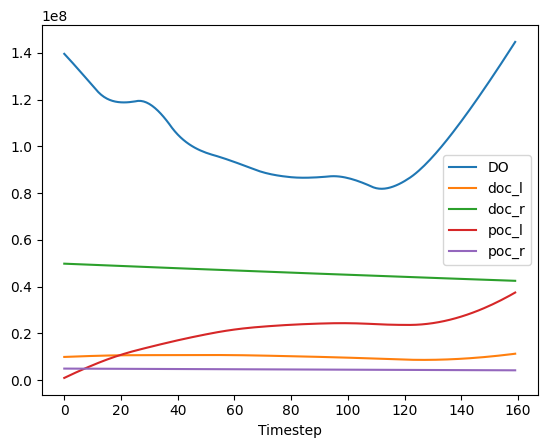

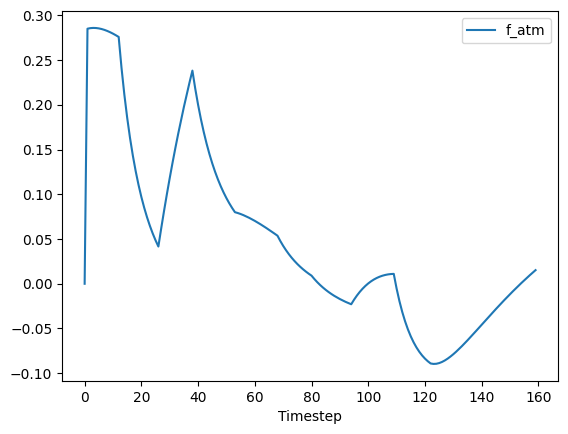

In [19]:
driver_data = pd.read_csv("D:\\bensd\Documents\RStudio Workspace\MetCL R ver\driver_data.csv")

# User defined parameters
ndays = len(driver_data.index)
lake_area = 100 * 10000 # m sq
altitude = 0 # meters above average sea level

# Model parameters
theta = 1.08 # Arrhenius scaling coefficient for temperature
rtheta = 1.08
gpptheta = 1.08
r_doc_r = 0.001 # First ordar decay rate
r_doc_l = 0.01
r_poc_r = 0.1
r_poc_l = 0.1
k = 1
z = driver_data['thermocline'].tolist()
constant_r = 1
constant_npp = 0.001
pmax = 1
c_npp = 0.8 # ratio of POC:DOC in NPP 
c_to_o = 2.67 # Carbon conversion to Oxygen

# Input data 
irr = driver_data['shortwave'].tolist()
temp = driver_data['temp'].tolist()
tp = driver_data['tp'].tolist()
barometric_pressure = 982.2 # millibars. Single value, optional
salinity = [0] * ndays # PSU, list of ndays length

# State variables
do = []
doc_l = []
doc_r = []
poc_l = []
poc_r = []

do.append(14 * lake_area * z[0]) # g do
doc_l.append(1 * lake_area * z[0])
doc_r.append(5 * lake_area * z[0])
poc_l.append(0.1 * lake_area * z[0])
poc_r.append(0.5 * lake_area * z[0])

# Rates
npp_obj = [0]
r_doc_r_obj = [0]
r_doc_l_obj = [0]
r_poc_r_obj = [0]
r_poc_l_obj = [0]
f_atm = [0]
# sediment respiration later

for i in list(range(1, ndays)):
    npp_obj.append(npp_calc(constant = constant_npp, irr = irr[i], ip = 1, temp = temp[i], tp = tp[i], pmax = pmax, v = lake_area * z[0])) # will refer to previous timestep in real run
    r_doc_r_obj.append(r_calc(constant = constant_r, carbon = doc_r[i-1], rrate = r_doc_r, do_conc = do[i-1] / lake_area * z[0], do_half = 0.5))
    r_doc_l_obj.append(r_calc(constant = constant_r, carbon = doc_l[i-1], rrate = r_doc_l, do_conc = do[i-1] / lake_area * z[0], do_half = 0.5))
    r_poc_r_obj.append(r_calc(constant = constant_r, carbon = poc_r[i-1], rrate = r_doc_r, do_conc = do[i-1] / lake_area * z[0], do_half = 0.5))
    r_poc_l_obj.append(r_calc(constant = constant_r, carbon = poc_l[i-1], rrate = r_doc_l, do_conc = do[i-1] / lake_area * z[0], do_half = 0.5))
    f_atm.append(f_atm_calc(k = k, do = do[i-1] / (lake_area * z[i]), do_sat = do_sat_calc(temp = temp[i], baro = barometric_pressure, altitude = altitude, salinity = salinity[i]), z = z[i]))
    # print(do_sat_calc(temp = temp[i], baro = barometric_pressure, altitude = altitude, salinity = salinity[i]))

    # Mass balance
    do.append(do[i-1] + (npp_obj[i] * c_to_o) - (r_doc_r_obj[i] * c_to_o) - (r_doc_l_obj[i] * c_to_o) - (r_poc_r_obj[i] * c_to_o) - (r_poc_l_obj[i] * c_to_o) - (f_atm[i] * 100 * 10000 * z[i]))
    doc_l.append(doc_l[i-1] + (npp_obj[i] * (1 - c_npp)) - r_doc_l_obj[i])
    doc_r.append(doc_r[i-1] - r_doc_r_obj[i])
    poc_l.append(poc_l[i-1] + (npp_obj[i] * (c_npp)) - r_poc_l_obj[i])
    poc_r.append(poc_r[i-1] - r_poc_r_obj[i])
    
    
df = pd.DataFrame({"Timestep":list(range(0, ndays)),
                   "DO":do,
                  "doc_l":doc_l,
                  "doc_r":doc_r,
                  "poc_l":poc_l,
                  "poc_r":poc_r,
                  "f_atm":f_atm,
                  "npp_r":npp_obj,
                  "r_doc_r":r_doc_r_obj,
                  "r_doc_l":r_doc_l_obj,
                  "r_poc_r":r_poc_r_obj,
                  "r_poc_l":r_poc_l_obj})
print(df)
df.plot(x='Timestep', y=["DO", "doc_l", "doc_r", "poc_l", "poc_r"], kind = "line")
df.plot(x = 'Timestep', y = 'f_atm', kind = 'line')

In [20]:
df.to_csv("D:/bensd/Documents/RStudio Workspace/MetCL R ver/onelayer_model_output_drivers.csv")